In [12]:
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, ViTConfig
import time

In [13]:
# Use CPU
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [14]:
# Load and modify the ViT configuration
print("Initializing ViT model...")
config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
config.num_channels = 1  # Change from RGB (3 channels) to Grayscale (1 channel)
config.image_size = 224  # Ensure model expects 224x224 input

Initializing ViT model...


In [15]:
# Initialize model with modified config
model = ViTForImageClassification(config)

# Adjust patch embeddings to accept single-channel input
model.vit.embeddings.patch_embeddings.projection = nn.Conv2d(
    in_channels=1, out_channels=config.hidden_size, kernel_size=16, stride=16
)

# Move model to CPU
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [16]:
# Function to pad images from (64, 72) to (224, 224)
def pad_images(images):
    padded = torch.zeros((images.shape[0], 1, 224, 224), dtype=torch.float32)
    padded[:, :, :64, :72] = images  # Place original images in top-left corner
    return padded

# Load datasets
print("Loading datasets...")
data1 = np.load("Run355456_Dataset_jqkne.npy")  # Shape: (N1, 64, 72)
data2 = np.load("Run357479_Dataset_iodic.npy")  # Shape: (N2, 64, 72)

# Normalize data (important for convergence)
print("Normalizing datasets...")
data1 = data1 / data1.max()
data2 = data2 / data2.max()

# Assign labels
labels1 = np.zeros(len(data1), dtype=np.int64)  # Class 0
labels2 = np.ones(len(data2), dtype=np.int64)   # Class 1

# Merge datasets
print("Merging datasets...")
data = np.concatenate((data1, data2), axis=0)  # (Total_N, 64, 72)
labels = np.concatenate((labels1, labels2), axis=0)  # (Total_N,)

# Convert to PyTorch tensors
print("Converting datasets to PyTorch tensors...")
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # (N, 1, 64, 72)
data = pad_images(data)  # Convert (1, 64, 72) → (1, 224, 224)
labels = torch.tensor(labels, dtype=torch.long)


Loading datasets...
Normalizing datasets...
Merging datasets...
Converting datasets to PyTorch tensors...


In [17]:
# Train/Val/Test split (70-20-10)
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

print(f"Dataset split: {train_size} train, {val_size} val, {test_size} test.")
train_data, val_data, test_data = random_split(TensorDataset(data, labels), [train_size, val_size, test_size])

# Initialize DataLoaders with smaller batch size for CPU
batch_size = 16 # Reduced batch size for CPU
print(f"Initializing DataLoaders with batch size {batch_size}...")
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=0)

Dataset split: 14000 train, 4000 val, 2000 test.
Initializing DataLoaders with batch size 16...


In [18]:
# Loss and Optimizer
print("Setting up optimizer and loss function...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

Setting up optimizer and loss function...


In [19]:
# Training parameters
epochs = 5
best_val_acc = 0.0
best_train_acc = 0.0


In [20]:
# Helper function for validation
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return val_loss / len(val_loader), correct / total

In [24]:

print("\n--- Training Starts ---")
for epoch in range(epochs):
    start_time = time.time()
    print(f"\n🚀 Epoch {epoch+1}/{epochs} starts...")
    
    # Training phase
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress
        if (batch_idx + 1) % 10 == 0 or batch_idx + 1 == len(train_loader):
            print(f"  Batch {batch_idx + 1}/{len(train_loader)} | "
                  f"Loss: {total_loss/(batch_idx+1):.4f} | "
                  f"Acc: {correct/total:.4f}")
    
    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    
    # Validation phase
    val_loss, val_acc = validate(model, val_loader)
    
    # Update scheduler based on validation accuracy
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_val_acc or train_acc > best_train_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        torch.save(model.state_dict(), "best_vit_model_jupyternotebook.pth")
        print(f"  💾 New best model saved with validation accuracy: {val_acc:.4f}")
    
    # Print epoch summary
    epoch_time = time.time() - start_time
    print(f"✅ Epoch {epoch+1} completed in {epoch_time:.1f}s | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



--- Training Starts ---

🚀 Epoch 1/5 starts...
  Batch 10/875 | Loss: 0.7614 | Acc: 0.4375
  Batch 20/875 | Loss: 0.7382 | Acc: 0.4813
  Batch 30/875 | Loss: 0.7245 | Acc: 0.5021
  Batch 40/875 | Loss: 0.6743 | Acc: 0.5750
  Batch 50/875 | Loss: 0.5607 | Acc: 0.6600
  Batch 60/875 | Loss: 0.4675 | Acc: 0.7167
  Batch 70/875 | Loss: 0.4065 | Acc: 0.7562
  Batch 80/875 | Loss: 0.3717 | Acc: 0.7805
  Batch 90/875 | Loss: 0.3440 | Acc: 0.8028
  Batch 100/875 | Loss: 0.3125 | Acc: 0.8213
  Batch 110/875 | Loss: 0.2857 | Acc: 0.8375
  Batch 120/875 | Loss: 0.2623 | Acc: 0.8510
  Batch 130/875 | Loss: 0.2428 | Acc: 0.8620
  Batch 140/875 | Loss: 0.2289 | Acc: 0.8710
  Batch 150/875 | Loss: 0.2152 | Acc: 0.8792
  Batch 160/875 | Loss: 0.2023 | Acc: 0.8867
  Batch 170/875 | Loss: 0.1904 | Acc: 0.8934
  Batch 180/875 | Loss: 0.1799 | Acc: 0.8993
  Batch 190/875 | Loss: 0.1704 | Acc: 0.9046
  Batch 200/875 | Loss: 0.1619 | Acc: 0.9094
  Batch 210/875 | Loss: 0.1567 | Acc: 0.9134
  Batch 220/875 

In [28]:
# Load best model for final evaluation
print("\n--- Final Evaluation ---")
model.load_state_dict(torch.load("best_vit_model_jupyternotebook.pth"))
model.eval()


--- Final Evaluation ---


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe


🏁 Final Test Results | Loss: 0.0000 | Accuracy: 1.0000 | AUC: 1.0000


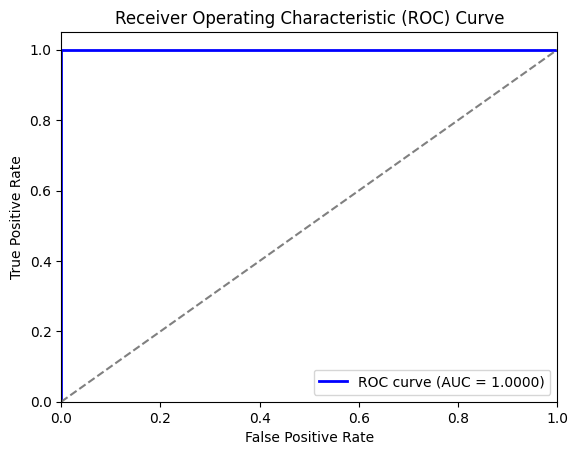

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize test loss and tracking variables
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Accumulate test loss
        test_loss += loss.item()
        
        # Get predictions
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        _, predicted = torch.max(outputs.data, 1)
        
        # Store values for evaluation
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute final loss and accuracy
test_loss = test_loss / len(test_loader)
test_acc = correct / total

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Print final test results
print(f"\n🏁 Final Test Results | Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | AUC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()